In [ ]:
!pip install optuna
!pip install optuna-integration
!pip install kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import random
import lightgbm as lgb
from optuna.integration import lightgbm as gbm
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 9.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#ドライブにマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#データの読み込み
df_train = pd.read_csv('drive/MyDrive/SMBC/train_SMBC.csv')
df_test = pd.read_csv('drive/MyDrive/SMBC/test_SMBC.csv')

#タグ付け
df_train['tag'] = 0
df_test['tag'] = 1

#結合と削除
df = pd.concat([df_train, df_test],axis=0)
df.drop('Unnamed: 0',axis=1,inplace=True)
df.columns

Index(['FacilityName', 'Latitude', 'Longitude', 'LocationAddress', 'City',
       'State', 'ZIP', 'County', 'FIPScode', 'PrimaryNAICS',
       'SecondPrimaryNAICS', 'IndustryType', 'TRI_Air_Emissions_10_in_lbs',
       'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons', 'tag'],
      dtype='object')

In [ ]:
# カラムのエンコード
from sklearn.preprocessing import LabelEncoder
le_state = LabelEncoder()
le_city = LabelEncoder()
le_county = LabelEncoder()
le_IndustryType = LabelEncoder()

df['State'] = le_state.fit_transform(df['State'])
df['City'] = le_city.fit_transform(df['City'])
df['County'] = le_county.fit_transform(df['County'])
df['IndustryType'] = le_IndustryType.fit_transform(df['IndustryType'])

In [ ]:
two_digit_map     = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

df['first_two_digit_primary_naics'] = df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)
df['Economic_Sector'] = df['first_two_digit_primary_naics'].map(two_digit_map)
df['Economic_Sector'] = le_IndustryType.fit_transform(df['Economic_Sector'])
del df['first_two_digit_primary_naics']

In [ ]:
#時系列データの追加
df['diff_Direct_Emissions11_10'] = df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']
df['diff_Direct_Emissions12_11'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
df['diff_Direct_Emissions13_12'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']

df['diff_Direct_Emissions12_10'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']
df['diff_Direct_Emissions13_11'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
df['diff_Direct_Emissions13_10'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']

df['rate_Direct_Emissions11_10'] = df['diff_Direct_Emissions11_10']/df['GHG_Direct_Emissions_10_in_metric_tons']
df['rate_Direct_Emissions12_11'] = df['diff_Direct_Emissions12_11']/df['GHG_Direct_Emissions_11_in_metric_tons']
df['rate_Direct_Emissions13_12'] = df['diff_Direct_Emissions13_12']/df['GHG_Direct_Emissions_12_in_metric_tons']

df['rate_Direct_Emissions12_10'] = df['diff_Direct_Emissions12_10']/df['GHG_Direct_Emissions_10_in_metric_tons']
df['rate_Direct_Emissions13_11'] = df['diff_Direct_Emissions13_11']/df['GHG_Direct_Emissions_11_in_metric_tons']
df['rate_Direct_Emissions13_10'] = df['diff_Direct_Emissions13_10']/df['GHG_Direct_Emissions_10_in_metric_tons']

df['total_Direct_Emissions'] = df['GHG_Direct_Emissions_10_in_metric_tons'] + df['GHG_Direct_Emissions_11_in_metric_tons'] + df['GHG_Direct_Emissions_12_in_metric_tons'] + df['GHG_Direct_Emissions_13_in_metric_tons']
df['total_Air_Emissions'] = df['TRI_Air_Emissions_10_in_lbs'] + df['TRI_Air_Emissions_11_in_lbs'] + df['TRI_Air_Emissions_12_in_lbs'] + df['TRI_Air_Emissions_13_in_lbs']


In [ ]:
features_list =['Latitude',
                'Longitude',
                'State',
                'City',
                'County',
                'Economic_Sector',
                'IndustryType',
                'TRI_Air_Emissions_10_in_lbs',
                'TRI_Air_Emissions_11_in_lbs',
                'TRI_Air_Emissions_12_in_lbs',
                'TRI_Air_Emissions_13_in_lbs',
                'GHG_Direct_Emissions_10_in_metric_tons',
                'GHG_Direct_Emissions_11_in_metric_tons',
                'GHG_Direct_Emissions_12_in_metric_tons',
                'GHG_Direct_Emissions_13_in_metric_tons',
                'diff_Direct_Emissions11_10',
                'diff_Direct_Emissions12_11',
                'diff_Direct_Emissions13_12',
                'diff_Direct_Emissions12_10',
                'diff_Direct_Emissions13_11',
                'diff_Direct_Emissions13_10',
                'rate_Direct_Emissions11_10',
                'rate_Direct_Emissions12_11',
                'rate_Direct_Emissions13_12',
                'rate_Direct_Emissions12_10',
                'rate_Direct_Emissions13_11',
                'rate_Direct_Emissions13_10',
                'total_Direct_Emissions',
                'total_Air_Emissions']

In [ ]:
#分割
df_train = df[df['tag']==0]
df_test = df[df['tag']==1]

In [ ]:
#上位MSE×標準偏差0.3未満
features1 = ['GHG_Direct_Emissions_11_in_metric_tons', 'diff_Direct_Emissions13_12', 'rate_Direct_Emissions13_10', 'GHG_Direct_Emissions_12_in_metric_tons', 'City', 'Longitude', 'State', 'rate_Direct_Emissions13_11', 'rate_Direct_Emissions12_11', 'TRI_Air_Emissions_10_in_lbs', 'total_Direct_Emissions', 'Latitude', 'GHG_Direct_Emissions_13_in_metric_tons', 'diff_Direct_Emissions12_11', 'total_Air_Emissions', 'diff_Direct_Emissions13_11', 'TRI_Air_Emissions_12_in_lbs', 'Economic_Sector', 'rate_Direct_Emissions12_10', 'diff_Direct_Emissions13_10', 'TRI_Air_Emissions_13_in_lbs']
features2 = ['State', 'diff_Direct_Emissions13_11', 'IndustryType', 'total_Air_Emissions', 'rate_Direct_Emissions12_10', 'rate_Direct_Emissions13_12', 'County', 'TRI_Air_Emissions_12_in_lbs', 'Latitude', 'total_Direct_Emissions', 'rate_Direct_Emissions12_11', 'diff_Direct_Emissions11_10', 'TRI_Air_Emissions_10_in_lbs', 'rate_Direct_Emissions11_10', 'City', 'Economic_Sector', 'GHG_Direct_Emissions_12_in_metric_tons', 'diff_Direct_Emissions12_11', 'GHG_Direct_Emissions_11_in_metric_tons', 'TRI_Air_Emissions_13_in_lbs', 'diff_Direct_Emissions13_12', 'GHG_Direct_Emissions_13_in_metric_tons', 'Longitude', 'diff_Direct_Emissions12_10']
features3 = ['GHG_Direct_Emissions_13_in_metric_tons', 'rate_Direct_Emissions13_12', 'total_Air_Emissions', 'diff_Direct_Emissions13_12', 'diff_Direct_Emissions12_11', 'diff_Direct_Emissions13_10', 'State', 'TRI_Air_Emissions_10_in_lbs', 'diff_Direct_Emissions12_10', 'Longitude', 'IndustryType', 'GHG_Direct_Emissions_10_in_metric_tons', 'rate_Direct_Emissions13_10', 'GHG_Direct_Emissions_11_in_metric_tons', 'TRI_Air_Emissions_11_in_lbs', 'Latitude', 'diff_Direct_Emissions11_10', 'TRI_Air_Emissions_12_in_lbs']
features4 = ['diff_Direct_Emissions13_12', 'total_Air_Emissions', 'State', 'TRI_Air_Emissions_10_in_lbs', 'Longitude', 'IndustryType', 'rate_Direct_Emissions11_10', 'rate_Direct_Emissions13_10', 'diff_Direct_Emissions13_11', 'TRI_Air_Emissions_12_in_lbs', 'City', 'rate_Direct_Emissions12_11', 'diff_Direct_Emissions11_10', 'TRI_Air_Emissions_11_in_lbs', 'Economic_Sector', 'Latitude', 'diff_Direct_Emissions12_11', 'rate_Direct_Emissions13_11', 'GHG_Direct_Emissions_12_in_metric_tons', 'total_Direct_Emissions', 'GHG_Direct_Emissions_13_in_metric_tons', 'rate_Direct_Emissions12_10', 'TRI_Air_Emissions_13_in_lbs', 'diff_Direct_Emissions12_10']
features5 = ['TRI_Air_Emissions_13_in_lbs', 'rate_Direct_Emissions13_11', 'GHG_Direct_Emissions_13_in_metric_tons', 'IndustryType', 'TRI_Air_Emissions_11_in_lbs', 'rate_Direct_Emissions11_10', 'State', 'diff_Direct_Emissions13_12', 'GHG_Direct_Emissions_10_in_metric_tons', 'County', 'rate_Direct_Emissions12_11', 'GHG_Direct_Emissions_12_in_metric_tons']
features6 = ['diff_Direct_Emissions12_11', 'Longitude', 'diff_Direct_Emissions13_10', 'IndustryType', 'State', 'rate_Direct_Emissions13_12', 'Economic_Sector', 'County', 'rate_Direct_Emissions12_11', 'diff_Direct_Emissions13_12', 'total_Air_Emissions', 'GHG_Direct_Emissions_13_in_metric_tons', 'total_Direct_Emissions', 'rate_Direct_Emissions11_10', 'TRI_Air_Emissions_11_in_lbs', 'rate_Direct_Emissions13_11', 'diff_Direct_Emissions13_11', 'TRI_Air_Emissions_10_in_lbs', 'Latitude', 'rate_Direct_Emissions12_10', 'City', 'diff_Direct_Emissions12_10', 'GHG_Direct_Emissions_10_in_metric_tons', 'rate_Direct_Emissions13_10']
features7 = ['total_Direct_Emissions', 'rate_Direct_Emissions13_11', 'diff_Direct_Emissions13_12', 'GHG_Direct_Emissions_12_in_metric_tons', 'rate_Direct_Emissions13_10', 'TRI_Air_Emissions_13_in_lbs', 'Longitude', 'rate_Direct_Emissions12_10', 'diff_Direct_Emissions12_11', 'County', 'diff_Direct_Emissions12_10', 'rate_Direct_Emissions11_10', 'TRI_Air_Emissions_10_in_lbs', 'rate_Direct_Emissions12_11', 'Latitude', 'TRI_Air_Emissions_12_in_lbs', 'Economic_Sector', 'State', 'GHG_Direct_Emissions_13_in_metric_tons', 'IndustryType', 'diff_Direct_Emissions13_10', 'GHG_Direct_Emissions_10_in_metric_tons', 'City', 'TRI_Air_Emissions_11_in_lbs']
features8 = ['Latitude', 'rate_Direct_Emissions11_10', 'City', 'GHG_Direct_Emissions_13_in_metric_tons', 'rate_Direct_Emissions12_10', 'rate_Direct_Emissions13_10', 'rate_Direct_Emissions13_12', 'TRI_Air_Emissions_13_in_lbs', 'IndustryType', 'diff_Direct_Emissions12_10', 'Longitude', 'TRI_Air_Emissions_10_in_lbs', 'GHG_Direct_Emissions_11_in_metric_tons', 'diff_Direct_Emissions12_11', 'TRI_Air_Emissions_11_in_lbs', 'County']
features9 = ['GHG_Direct_Emissions_10_in_metric_tons', 'rate_Direct_Emissions13_10', 'Longitude', 'rate_Direct_Emissions11_10', 'State', 'diff_Direct_Emissions12_10', 'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_13_in_lbs', 'diff_Direct_Emissions12_11', 'IndustryType', 'City', 'Economic_Sector', 'GHG_Direct_Emissions_12_in_metric_tons', 'diff_Direct_Emissions13_11', 'rate_Direct_Emissions12_10', 'GHG_Direct_Emissions_13_in_metric_tons', 'rate_Direct_Emissions13_12', 'rate_Direct_Emissions13_11', 'total_Air_Emissions', 'diff_Direct_Emissions13_10', 'GHG_Direct_Emissions_11_in_metric_tons', 'TRI_Air_Emissions_12_in_lbs', 'County', 'diff_Direct_Emissions11_10', 'diff_Direct_Emissions13_12', 'TRI_Air_Emissions_10_in_lbs', 'Latitude', 'rate_Direct_Emissions12_11']
features10 = ['rate_Direct_Emissions12_10', 'GHG_Direct_Emissions_13_in_metric_tons', 'IndustryType', 'GHG_Direct_Emissions_11_in_metric_tons', 'diff_Direct_Emissions13_12', 'rate_Direct_Emissions13_12', 'total_Air_Emissions', 'diff_Direct_Emissions12_10', 'diff_Direct_Emissions13_11', 'rate_Direct_Emissions13_10', 'rate_Direct_Emissions11_10', 'diff_Direct_Emissions12_11', 'State', 'diff_Direct_Emissions13_10', 'City', 'GHG_Direct_Emissions_10_in_metric_tons', 'Longitude', 'TRI_Air_Emissions_11_in_lbs', 'rate_Direct_Emissions13_11']

features_top10 = [features1,features2,features3,features4,features5,features6,features7,features8,features9,features10]

In [ ]:
len(features3)

18

In [ ]:
from collections import Counter

# データリスト
data = [
    features1, features2, features3, features4, features5,
    features6, features7, features8, features9, features10
]

# 全要素を結合してカウント
all_features = [feature for features in data for feature in features]
count_features = Counter(all_features)

# 出力
for feature, count in count_features.items():
    print(f"{feature}: {count}")

GHG_Direct_Emissions_11_in_metric_tons: 6
diff_Direct_Emissions13_12: 9
rate_Direct_Emissions13_10: 8
GHG_Direct_Emissions_12_in_metric_tons: 6
City: 8
Longitude: 9
State: 9
rate_Direct_Emissions13_11: 7
rate_Direct_Emissions12_11: 7
TRI_Air_Emissions_10_in_lbs: 8
total_Direct_Emissions: 5
Latitude: 8
GHG_Direct_Emissions_13_in_metric_tons: 10
diff_Direct_Emissions12_11: 9
total_Air_Emissions: 7
diff_Direct_Emissions13_11: 6
TRI_Air_Emissions_12_in_lbs: 6
Economic_Sector: 6
rate_Direct_Emissions12_10: 8
diff_Direct_Emissions13_10: 6
TRI_Air_Emissions_13_in_lbs: 7
IndustryType: 9
rate_Direct_Emissions13_12: 6
County: 6
diff_Direct_Emissions11_10: 4
rate_Direct_Emissions11_10: 8
diff_Direct_Emissions12_10: 8
GHG_Direct_Emissions_10_in_metric_tons: 6
TRI_Air_Emissions_11_in_lbs: 8


In [ ]:
%%capture
#ファイル出力用
#説明変数選択から得られた結果を入力
MSE = []
for i, features in enumerate(features_top10):
    #説明変数
    features_train = df_train[features]
    features_test = df_test[features]
    #ターゲット
    target_train_ori = df_train['GHG_Direct_Emissions_14_in_metric_tons']
    target_train = np.log(target_train_ori+1)

    # データの分割
    train_data, val_data, train_target, val_target = train_test_split(features_train, target_train, test_size=0.2, random_state=123)

    # LightGBM用データセット作成
    lgb_train = gbm.Dataset(train_data, train_target)

    # 固定するパラメータ
    params = {
        "boosting_type": "gbdt",
        'objective': 'regression',
        'metric': 'rmse',
        "verbosity": -1,
        'early_stopping_round': 30  # ここでearly_stoppingを指定
    }

    # KFoldを設定
    kf = KFold(n_splits=6, shuffle=True, random_state=777)

    # Optunaを使用したクロスバリデーションでのパラメータチューニング
    tuner = gbm.LightGBMTunerCV(
        params,
        lgb_train,
        folds=kf,
        return_cvbooster=True
    )

    # パラメータチューニングの実行
    tuner.run()

    # 最良モデルで予測
    best_params = tuner.best_params

    #best_param
    # 最良モデルの取得
    cv_booster = tuner.get_best_booster()

    # 各フォールドの予測をマージ
    log_y_pred = np.mean([booster.predict(val_data, num_iteration=booster.best_iteration) for booster in cv_booster.boosters], axis=0)
    y_pred = np.exp(log_y_pred)-1

    #MSEの出力
    val_target_ = np.exp(val_target)-1
    mse = mean_squared_log_error(val_target_, y_pred)
    MSE.append(mse)

    #csvファイルに書き出し
    #y_pred = cv_booster.predict(features_test, num_iteration=model.best_iteration)
    # 各フォールドの予測をマージ
    log_y_pred = np.mean([booster.predict(features_test, num_iteration=booster.best_iteration) for booster in cv_booster.boosters], axis=0)
    y_pred = np.exp(log_y_pred)-1
    index_list = range(4655,7163)
    df_pred = pd.DataFrame(y_pred,index_list)
    df_pred.to_csv(f'drive/MyDrive/SMBC/submission27_{i}.csv')

[I 2024-11-27 01:14:22,643] A new study created in memory with name: no-name-1098f18a-bbef-41f6-a1e9-3d3da1b05be1
[I 2024-11-27 01:14:23,153] Trial 0 finished with value: 0.7657590025419406 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.7657590025419406.
[I 2024-11-27 01:14:23,579] Trial 1 finished with value: 0.7631285662307113 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.7631285662307113.
[I 2024-11-27 01:14:24,013] Trial 2 finished with value: 0.7622863297557041 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.7622863297557041.
[I 2024-11-27 01:14:24,487] Trial 3 finished with value: 0.7650234227411673 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.7622863297557041.
[I 2024-11-27 01:14:24,904] Trial 4 finished with value: 0.7649466131128158 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.7622863297557041.
[I 2024-11-27 01:14:25,484] Trial 5 finished with v

In [ ]:
print(best_params)

{'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'early_stopping_round': 30, 'feature_pre_filter': False, 'lambda_l1': 3.329539714027614, 'lambda_l2': 9.954359228345108, 'num_leaves': 4, 'feature_fraction': 0.8, 'bagging_fraction': 0.6660951100962775, 'bagging_freq': 1, 'min_child_samples': 10}


In [ ]:
print(f"\nMean Squared Error: {mse}")
print(f"Best Parameters: {best_params}")
print(MSE)


Mean Squared Error: 0.6175937048617216
Best Parameters: {'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'early_stopping_round': 30, 'feature_pre_filter': False, 'lambda_l1': 0.0001372754939767386, 'lambda_l2': 0.01520649565732201, 'num_leaves': 5, 'feature_fraction': 0.7, 'bagging_fraction': 0.7950640487552844, 'bagging_freq': 4, 'min_child_samples': 20}
[0.614439906899707, 0.6143102497061894, 0.6096468657459629, 0.6109206816509974, 0.6135519415015815, 0.6196286165731179, 0.6076544228757425, 0.6209755079408132, 0.604803228125358, 0.6175937048617216]


In [ ]:
# 説明変数サーチ用 総当たり
df = pd.read_csv('drive/MyDrive/SMBC/scores.csv')
# info列を集合に変換
used_combinations = {tuple(eval(info)) for info in df['Features']}
# リスト形式に変換
scores = [[row['MSE'], eval(row['Features'])] for _, row in df.iterrows()]

In [ ]:
#説明変数サーチ用
%%capture
# 過去に選ばれた組み合わせを記録
for i in range(200):
    while True:
        # シャッフルしてから必要な個数を選択
        shuffled_features = features_list.copy()
        random.shuffle(shuffled_features)
        selected_features = tuple(shuffled_features[:random.randint(23, 28)])  # 必要な数だけ選択しタプル化

        # 過去に選ばれていない組み合わせであれば採用
        if selected_features not in used_combinations:
            used_combinations.add(selected_features)
            break

    features = list(selected_features)

    # 説明変数
    features_train = df_train[features]
    features_test = df_test[features]

    # ターゲット
    target_train_ori = df_train['GHG_Direct_Emissions_14_in_metric_tons']
    target_train = np.log(target_train_ori + 1)

    # データの分割
    train_data, val_data, train_target, val_target = train_test_split(features_train, target_train, test_size=0.1, random_state=7)

    # LightGBM用データセット作成
    lgb_train = gbm.Dataset(train_data, train_target)

    # 固定するパラメータ
    params = {
        "boosting_type": "gbdt",
        'objective': 'regression',
        'metric': 'rmse',
        "verbose_eval": -1,
        'early_stopping_round': 30  # ここでearly_stoppingを指定
    }

    # KFoldを設定
    kf = KFold(n_splits=6, shuffle=True, random_state=777)

    # Optunaを使用したクロスバリデーションでのパラメータチューニング
    tuner = gbm.LightGBMTunerCV(
        params,
        lgb_train,
        folds=kf,
        return_cvbooster=True
    )

    # パラメータチューニングの実行
    tuner.run()

    # 最良モデルで予測
    best_params = tuner.best_params

    # 最良モデルの取得
    cv_booster = tuner.get_best_booster()

    # 各フォールドの予測をマージ
    log_y_pred = np.mean([booster.predict(val_data, num_iteration=booster.best_iteration) for booster in cv_booster.boosters], axis=0)
    y_pred = np.exp(log_y_pred) - 1

    # MSEの出力
    val_target_ = np.exp(val_target) - 1
    mse = mean_squared_log_error(val_target_, y_pred)

    # 結果をまとめる
    score = [mse, features]
    scores.append(score)
    #スコアcsv形式で保存
    if i % 50 == 0:
        df_scores = pd.DataFrame(scores, columns=['MSE', 'Features'])
        df_scores.to_csv('drive/MyDrive/SMBC/scores.csv', index=False)


Streaming output truncated to the last 5000 lines.
[I 2024-11-24 16:41:19,083] Trial 51 finished with value: 0.7527936037708186 and parameters: {'lambda_l1': 1.0979750515875941e-05, 'lambda_l2': 7.122222713762195e-05}. Best is trial 44 with value: 0.7521458552679353.
[I 2024-11-24 16:41:19,434] Trial 52 finished with value: 0.7548567777538548 and parameters: {'lambda_l1': 9.070212212925611, 'lambda_l2': 0.005751099163952565}. Best is trial 44 with value: 0.7521458552679353.
[I 2024-11-24 16:41:19,739] Trial 53 finished with value: 0.7537987256638298 and parameters: {'lambda_l1': 0.005323903439800847, 'lambda_l2': 8.528302017108699}. Best is trial 44 with value: 0.7521458552679353.
[I 2024-11-24 16:41:20,075] Trial 54 finished with value: 0.7514905012630715 and parameters: {'lambda_l1': 0.4246518903202944, 'lambda_l2': 0.0012720576457437203}. Best is trial 54 with value: 0.7514905012630715.
[I 2024-11-24 16:41:20,343] Trial 55 finished with value: 0.7531378570446187 and parameters: {'la

In [ ]:
%%capture
# 説明変数サーチ 決勝戦
df = pd.read_csv('drive/MyDrive/SMBC/scores.csv')
scores = []
# 上位のものだけを対象にする
for _, row in df.iterrows():
    if 0.623 < row['MSE'] < 0.625:
        #説明変数
        features = eval(row['Features'])
        features_train = df_train[features]
        features_test = df_test[features]

        #ターゲット
        target_train_ori = df_train['GHG_Direct_Emissions_14_in_metric_tons']
        target_train = np.log(target_train_ori+1)

        #学習
        MSE = []
        for i in range(10):
            # データの分割
            train_data, val_data, train_target, val_target = train_test_split(features_train, target_train, test_size=0.2, random_state=random.randint(10, 500))

            # LightGBM用データセット作成
            lgb_train = gbm.Dataset(train_data, train_target)

            # 固定するパラメータ
            params = {
                "boosting_type": "gbdt",
                'objective': 'regression',
                'metric': 'rmse',
                "verbosity": -1,
                'early_stopping_round': 30  # ここでearly_stoppingを指定
            }

            # KFoldを設定
            kf = KFold(n_splits=6, shuffle=True, random_state=777)

            # Optunaを使用したクロスバリデーションでのパラメータチューニング
            tuner = gbm.LightGBMTunerCV(
                params,
                lgb_train,
                folds=kf,
                return_cvbooster=True
            )

            # パラメータチューニングの実行
            tuner.run()

            # 最良モデルで予測
            best_params = tuner.best_params

            #best_param
            # 最良モデルの取得
            cv_booster = tuner.get_best_booster()

            # 各フォールドの予測をマージ
            log_y_pred = np.mean([booster.predict(val_data, num_iteration=booster.best_iteration) for booster in cv_booster.boosters], axis=0)
            y_pred = np.exp(log_y_pred)-1

            #MSEの出力
            val_target_ = np.exp(val_target)-1
            mse = mean_squared_log_error(val_target_, y_pred)
            MSE.append(mse)

        # 結果をまとめる
        MSE_ave = np.mean(MSE)
        MSE_std = np.std(MSE)
        score = [MSE_ave, MSE_std, MSE, features]
        scores.append(score)

        #スコアcsv形式で保存
        if len(scores) % 20 == 0:
            df_scores = pd.DataFrame(scores, columns=['MSE_AVG','MSE_STD','MSE','Features'])
            df_scores.to_csv('drive/MyDrive/SMBC/scores_ave_under0.625.csv', index=False)

ストリーミング出力は最後の 5000 行に切り捨てられました。
[I 2024-11-26 13:03:56,679] Trial 57 finished with value: 0.7682139883205332 and parameters: {'lambda_l1': 0.0003866640805084517, 'lambda_l2': 0.09407473191921352}. Best is trial 45 with value: 0.7674660978902499.
[I 2024-11-26 13:03:56,895] Trial 58 finished with value: 0.7693732739625124 and parameters: {'lambda_l1': 9.613037205039268e-05, 'lambda_l2': 0.05246334305010615}. Best is trial 45 with value: 0.7674660978902499.
[I 2024-11-26 13:03:57,147] Trial 59 finished with value: 0.7677667401720055 and parameters: {'lambda_l1': 0.00014709514704639424, 'lambda_l2': 0.13584983224543876}. Best is trial 45 with value: 0.7674660978902499.
[I 2024-11-26 13:03:57,387] Trial 60 finished with value: 0.7680840420994803 and parameters: {'lambda_l1': 9.178507050367128e-05, 'lambda_l2': 0.17551744571676742}. Best is trial 45 with value: 0.7674660978902499.
[I 2024-11-26 13:03:57,622] Trial 61 finished with value: 0.7679697009065681 and parameters: {'lambda_l1': 4.97

In [ ]:
#csvファイルに書き出し
#y_pred = cv_booster.predict(features_test, num_iteration=model.best_iteration)
# 各フォールドの予測をマージ
log_y_pred = np.mean([booster.predict(features_test, num_iteration=booster.best_iteration) for booster in cv_booster.boosters], axis=0)
y_pred = np.exp(log_y_pred)-1
index_list = range(4655,7163)
df_pred = pd.DataFrame(y_pred,index_list)
df_pred.to_csv('drive/MyDrive/SMBC/submission26_5.csv')

[I 2024-11-21 00:29:39,573] A new study created in memory with name: no-name-5ad3ffed-4ecf-4c30-814f-be102cf38611

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(

feature_fraction, val_score: 0.773851:  14%|#4        | 1/7 [00:00<00:02,  2.45it/s][I 2024-11-21 00:29:39,997] Trial 0 finished with value: 0.7738512151189976 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.7738512151189976.

feature_fraction, val_score: 0.773851:  14%|#4        | 1/7 [00:00<00:02,  2.45it/s]/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(

feature_fraction, val_score: 0.771070:  29%|##8       | 2/7 [00:00<00:01,  2.60it/s][I 2024-11-21 00:29:40,364] Trial 1 finished with value: 0.7710700384783395 and parameters: {'

Mean Squared Error: 0.6322346079998166
Calculating SHAP values...


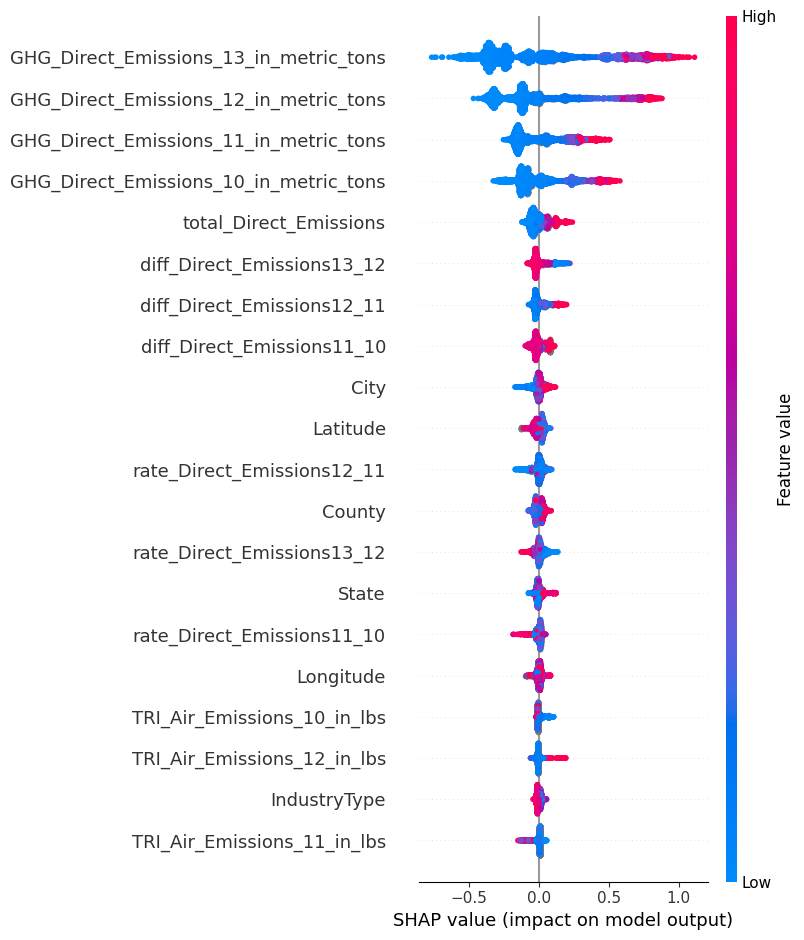

Plotting a single prediction explanation...


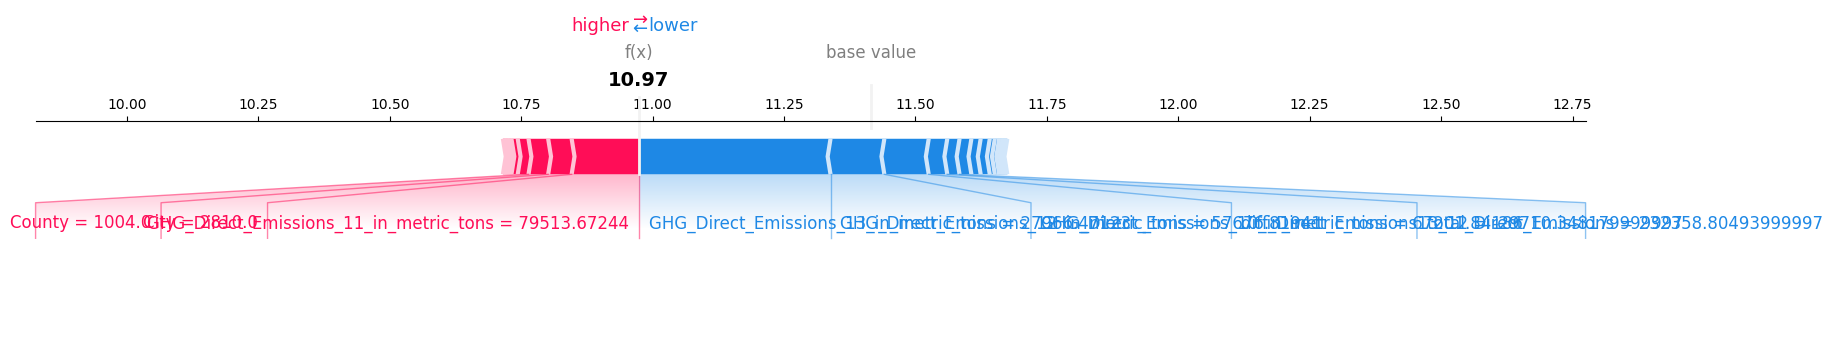

In [ ]:
import optuna.integration.lightgbm as gbm
import shap
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt

features = features_list

# 説明変数
features_train = df_train[features]
features_test = df_test[features]

# ターゲット
target_train_ori = df_train['GHG_Direct_Emissions_14_in_metric_tons']
target_train = np.log(target_train_ori + 1)

# データの分割
train_data, val_data, train_target, val_target = train_test_split(
    features_train, target_train, test_size=0.1, random_state=7
)

# LightGBM用データセット作成
lgb_train = gbm.Dataset(train_data, train_target)

# 固定するパラメータ
params = {
    "boosting_type": "gbdt",
    'objective': 'regression',
    'metric': 'rmse',
    "verbosity": -1,
    'early_stopping_round': 30
}

# KFoldを設定
kf = KFold(n_splits=2, shuffle=True, random_state=67)

# Optunaを使用したクロスバリデーションでのパラメータチューニング
tuner = gbm.LightGBMTunerCV(
    params,
    lgb_train,
    folds=kf,
    return_cvbooster=True
)

# パラメータチューニングの実行
tuner.run()

# 最良モデルで予測
best_params = tuner.best_params

# 最良モデルの取得
cv_booster = tuner.get_best_booster()

# 各フォールドの予測をマージ
log_y_pred = np.mean(
    [booster.predict(val_data, num_iteration=booster.best_iteration) for booster in cv_booster.boosters],
    axis=0
)
y_pred = np.exp(log_y_pred) - 1

# MSEの出力
val_target_ = np.exp(val_target) - 1
mse = mean_squared_log_error(val_target_, y_pred)
print(f"Mean Squared Error: {mse}")

# SHAP値の計算と可視化
print("Calculating SHAP values...")
model = cv_booster.boosters[0]  # 任意のフォールドモデルを選択
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_data)

# 要約プロット
shap.summary_plot(shap_values, train_data, feature_names=features)

# 特定のデータポイントの説明
print("Plotting a single prediction explanation...")
shap.force_plot(explainer.expected_value, shap_values[0], train_data.iloc[0], matplotlib=True)


In [ ]:
# %%capture
# # 変数リスト
# features =  ['State',
#   'IndustryType',
#   'diff_Direct_Emissions13_12',
#   'Latitude',
#   'TRI_Air_Emissions_10_in_lbs',
#   'Longitude',
#   'County',
#   'rate_Direct_Emissions13_12',
#   'rate_Direct_Emissions12_11',
#   'diff_Direct_Emissions13_10',
#   'total_Direct_Emissions',
#   'TRI_Air_Emissions_11_in_lbs',
#   'rate_Direct_Emissions13_11',
#   'City',
#   'TRI_Air_Emissions_12_in_lbs',
#   'GHG_Direct_Emissions_10_in_metric_tons',
#   'GHG_Direct_Emissions_11_in_metric_tons',
#   'diff_Direct_Emissions12_11',
#   'rate_Direct_Emissions11_10',
#   'rate_Direct_Emissions13_10',
#   'diff_Direct_Emissions11_10',
#   'diff_Direct_Emissions13_11',
#   'GHG_Direct_Emissions_13_in_metric_tons',
#   'rate_Direct_Emissions12_10',
#   'TRI_Air_Emissions_13_in_lbs',
#   'GHG_Direct_Emissions_12_in_metric_tons']

# # 説明変数とターゲット
# features_train = df_train[features]
# features_test = df_test[features]
# target_train_ori = df_train['GHG_Direct_Emissions_14_in_metric_tons']
# target_train = np.log(target_train_ori + 1)

# # データの分割
# train_data, val_data, train_target, val_target = train_test_split(
#     features_train, target_train, test_size=0.1, random_state=7
# )

# def objective(trial):
#     # Optunaで選択する変数を決定
#     selected_features = [
#         feature for feature in features
#         if trial.suggest_categorical(feature, [True, False])
#     ]
#     if len(selected_features) == 0:
#         return float("inf")  # 特徴量がすべて除外された場合、無限大を返す

#     # 選択した特徴量に基づいてデータを再構築
#     train_selected = train_data[selected_features]
#     val_selected = val_data[selected_features]

#     # LightGBM用データセット作成
#     lgb_train = lgb.Dataset(train_selected, train_target)
#     lgb_val = lgb.Dataset(val_selected, val_target, reference=lgb_train)

#     # 固定パラメータ
#     params = {
#         "boosting_type": "gbdt",
#         "objective": "tweedie",
#         "metric": "rmse",
#         "verbosity": -1
#     }

#     # モデルの学習
#     gbm = lgb.train(
#         params,
#         lgb_train,
#         valid_sets=[lgb_val],
#         num_boost_round=10000,
#         callbacks=[
#             lgb.early_stopping(stopping_rounds=30, verbose=False),
#             lgb.log_evaluation(10),
#         ],
#     )

#     # 予測と評価
#     log_y_pred = gbm.predict(val_selected, num_iteration=gbm.best_iteration)
#     y_pred = np.exp(log_y_pred) - 1
#     val_target_ = np.exp(val_target) - 1
#     mse = mean_squared_log_error(val_target_, y_pred)
#     return mse

# # Optunaによる最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

# # 最適な変数セット
# best_features = [
#     feature for feature in features
#     if study.best_trial.params.get(feature, False)
# ]
# print("Selected features:", best_features)

# # 最良のモデルで学習
# train_selected = train_data[best_features]
# val_selected = val_data[best_features]
# lgb_train = lgb.Dataset(train_selected, train_target)
# lgb_val = lgb.Dataset(val_selected, val_target, reference=lgb_train)

# gbm = lgb.train(
#     params,
#     lgb_train,
#     valid_sets=[lgb_val],
#     num_boost_round=10000,
#     callbacks=[
#         lgb.early_stopping(stopping_rounds=30, verbose=False),
#         lgb.log_evaluation(10),
#     ],
# )

# # 最終予測と評価
# log_y_pred = gbm.predict(val_selected, num_iteration=gbm.best_iteration)
# y_pred = np.exp(log_y_pred) - 1
# val_target_ = np.exp(val_target) - 1
# final_mse = mean_squared_log_error(val_target_, y_pred)
# print("Final MSLE:", final_mse)


[I 2024-11-20 09:16:48,910] A new study created in memory with name: no-name-412fb2d8-d979-403c-ba5a-394a72c1f1b6
[I 2024-11-20 09:16:49,079] Trial 0 finished with value: 0.6948764799018304 and parameters: {'Latitude': True, 'Longitude': False, 'State': False, 'City': True, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': True, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': True, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': False, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': True, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': True}. Best is trial 0 with value: 0.6948764799018304.


[10]	valid_0's rmse: 0.92309
[20]	valid_0's rmse: 0.848917
[30]	valid_0's rmse: 0.834556
[40]	valid_0's rmse: 0.83525
[50]	valid_0's rmse: 0.835865
[60]	valid_0's rmse: 0.842119
[10]	valid_0's rmse: 0.984014
[20]	valid_0's rmse: 0.924368


[I 2024-11-20 09:16:49,295] Trial 1 finished with value: 0.7959518393086016 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': False, 'County': True, 'Economic_Sector': True, 'IndustryType': True, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': True, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': False, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': True, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': True}. Best is trial 0 with value: 0.6948764799018304.


[30]	valid_0's rmse: 0.903555
[40]	valid_0's rmse: 0.897844
[50]	valid_0's rmse: 0.894189
[60]	valid_0's rmse: 0.892375
[70]	valid_0's rmse: 0.893511
[80]	valid_0's rmse: 0.894081
[10]	valid_0's rmse: 0.891303


[I 2024-11-20 09:16:49,471] Trial 2 finished with value: 0.6552347634380312 and parameters: {'Latitude': True, 'Longitude': False, 'State': False, 'City': False, 'County': False, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': True, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': True, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': True, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': True}. Best is trial 2 with value: 0.6552347634380312.


[20]	valid_0's rmse: 0.81754
[30]	valid_0's rmse: 0.811664
[40]	valid_0's rmse: 0.815317
[50]	valid_0's rmse: 0.818862
[10]	valid_0's rmse: 0.8959
[20]	valid_0's rmse: 0.822422
[30]	valid_0's rmse: 0.810319
[40]	valid_0's rmse: 0.814485


[I 2024-11-20 09:16:49,631] Trial 3 finished with value: 0.6556571952558504 and parameters: {'Latitude': True, 'Longitude': False, 'State': False, 'City': True, 'County': True, 'Economic_Sector': True, 'IndustryType': True, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': True, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': True, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': True, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 2 with value: 0.6552347634380312.
[I 2024-11-20 09:16:49,785] Trial 4 finished with value: 0.6753130105982771 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': False, 'Co

[50]	valid_0's rmse: 0.818447
[10]	valid_0's rmse: 0.90374
[20]	valid_0's rmse: 0.829896
[30]	valid_0's rmse: 0.821774
[40]	valid_0's rmse: 0.825541
[50]	valid_0's rmse: 0.82759
[60]	valid_0's rmse: 0.831138


[I 2024-11-20 09:16:49,975] Trial 5 finished with value: 0.6918118946013957 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': False, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': True, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': False, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': True, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 2 with value: 0.6552347634380312.


[10]	valid_0's rmse: 0.923064
[20]	valid_0's rmse: 0.843638
[30]	valid_0's rmse: 0.833165
[40]	valid_0's rmse: 0.834777
[50]	valid_0's rmse: 0.831752
[60]	valid_0's rmse: 0.835007
[70]	valid_0's rmse: 0.835774
[80]	valid_0's rmse: 0.837807
[10]	valid_0's rmse: 0.88972


[I 2024-11-20 09:16:50,186] Trial 6 finished with value: 0.6401604896461155 and parameters: {'Latitude': False, 'Longitude': True, 'State': True, 'City': True, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': True, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': True}. Best is trial 6 with value: 0.6401604896461155.


[20]	valid_0's rmse: 0.81019
[30]	valid_0's rmse: 0.8001
[40]	valid_0's rmse: 0.802513
[50]	valid_0's rmse: 0.804753
[60]	valid_0's rmse: 0.806269
[10]	valid_0's rmse: 0.897889
[20]	valid_0's rmse: 0.810722
[30]	valid_0's rmse: 0.796359
[40]	valid_0's rmse: 0.7957


[I 2024-11-20 09:16:50,324] Trial 7 finished with value: 0.6308006156084788 and parameters: {'Latitude': False, 'Longitude': False, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': True}. Best is trial 7 with value: 0.6308006156084788.


[50]	valid_0's rmse: 0.796404
[60]	valid_0's rmse: 0.796075
[70]	valid_0's rmse: 0.797047
[10]	valid_0's rmse: 0.960749
[20]	valid_0's rmse: 0.885826
[30]	valid_0's rmse: 0.873593
[40]	valid_0's rmse: 0.873339
[50]	valid_0's rmse: 0.87489
[60]	valid_0's rmse: 0.876057


[I 2024-11-20 09:16:50,485] Trial 8 finished with value: 0.7594703443331274 and parameters: {'Latitude': True, 'Longitude': True, 'State': True, 'City': False, 'County': True, 'Economic_Sector': True, 'IndustryType': True, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': False, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': True}. Best is trial 7 with value: 0.6308006156084788.
[I 2024-11-20 09:16:50,650] Trial 9 finished with value: 0.6936921901205285 and parameters: {'Latitude': True, 'Longitude': False, 'State': False, 'City': False, 

[10]	valid_0's rmse: 0.940221
[20]	valid_0's rmse: 0.855551
[30]	valid_0's rmse: 0.834968
[40]	valid_0's rmse: 0.834274
[50]	valid_0's rmse: 0.83711
[60]	valid_0's rmse: 0.835748
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653


[I 2024-11-20 09:16:50,795] Trial 10 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.
[I 2024-11-20 09:16:50,938] Trial 11 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': 

[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507


[I 2024-11-20 09:16:51,089] Trial 12 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844


[I 2024-11-20 09:16:51,273] Trial 13 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748


[I 2024-11-20 09:16:51,442] Trial 14 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.
[I 2024-11-20 09:16:51,590] Trial 15 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': 

[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507


[I 2024-11-20 09:16:51,731] Trial 16 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748


[I 2024-11-20 09:16:51,876] Trial 17 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.892486
[20]	valid_0's rmse: 0.807733
[30]	valid_0's rmse: 0.796184
[40]	valid_0's rmse: 0.79384
[50]	valid_0's rmse: 0.796477
[60]	valid_0's rmse: 0.799059


[I 2024-11-20 09:16:52,056] Trial 18 finished with value: 0.6300460747236832 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': True, 'TRI_Air_Emissions_10_in_lbs': True, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': True, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.
[I 2024-11-20 09:16:52,216] Trial 19 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': Tru

[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653


[I 2024-11-20 09:16:52,373] Trial 20 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507


[I 2024-11-20 09:16:52,546] Trial 21 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.
[I 2024-11-20 09:16:52,683] Trial 22 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': 

[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748


[I 2024-11-20 09:16:52,849] Trial 23 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.
[I 2024-11-20 09:16:52,993] Trial 24 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': 

[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507


[I 2024-11-20 09:16:53,163] Trial 25 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.891371


[I 2024-11-20 09:16:53,380] Trial 26 finished with value: 0.6388063569056036 and parameters: {'Latitude': False, 'Longitude': True, 'State': True, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': True, 'TRI_Air_Emissions_10_in_lbs': True, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': True, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': True, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': True, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[20]	valid_0's rmse: 0.811493
[30]	valid_0's rmse: 0.800149
[40]	valid_0's rmse: 0.800493
[50]	valid_0's rmse: 0.804029
[60]	valid_0's rmse: 0.801849
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507


[I 2024-11-20 09:16:53,879] Trial 27 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748


[I 2024-11-20 09:16:54,589] Trial 28 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.905168
[20]	valid_0's rmse: 0.833212
[30]	valid_0's rmse: 0.826921
[40]	valid_0's rmse: 0.827805


[I 2024-11-20 09:16:55,198] Trial 29 finished with value: 0.6829730227256967 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': True, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': True, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': True, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': False, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': True, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[50]	valid_0's rmse: 0.835341
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844


[I 2024-11-20 09:16:55,554] Trial 30 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748


[I 2024-11-20 09:16:55,941] Trial 31 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507


[I 2024-11-20 09:16:56,562] Trial 32 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': True, 'County': False, 'Economic_Sector': False, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': False, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.
[I 2024-11-20 09:16:56,860] Trial 33 finished with value: 0.6276856146708727 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': 

[10]	valid_0's rmse: 0.888487
[20]	valid_0's rmse: 0.808844
[30]	valid_0's rmse: 0.794653
[40]	valid_0's rmse: 0.792562
[50]	valid_0's rmse: 0.79748
[60]	valid_0's rmse: 0.798507
[10]	valid_0's rmse: 0.918648
[20]	valid_0's rmse: 0.840381
[30]	valid_0's rmse: 0.826891


[I 2024-11-20 09:16:57,045] Trial 34 finished with value: 0.6734721706411135 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': False, 'County': True, 'Economic_Sector': False, 'IndustryType': True, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': True, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': True, 'GHG_Direct_Emissions_11_in_metric_tons': False, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': False, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': True, 'rate_Direct_Emissions12_11': True, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.


[40]	valid_0's rmse: 0.821356
[50]	valid_0's rmse: 0.824354
[60]	valid_0's rmse: 0.824819
[10]	valid_0's rmse: 0.92512
[20]	valid_0's rmse: 0.862739
[30]	valid_0's rmse: 0.857408
[40]	valid_0's rmse: 0.861591
[50]	valid_0's rmse: 0.865642


[I 2024-11-20 09:16:57,204] Trial 35 finished with value: 0.7341649458194339 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': True, 'County': False, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': False, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': True, 'GHG_Direct_Emissions_13_in_metric_tons': False, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': False, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 10 with value: 0.6276856146708727.
[I 2024-11-20 09:16:57,395] Trial 36 finished with value: 0.6482825153321107 and parameters: {'Latitude': False, 'Longitude': True, 'State': False, 'City': Fa

[10]	valid_0's rmse: 0.890642
[20]	valid_0's rmse: 0.815193
[30]	valid_0's rmse: 0.80528
[40]	valid_0's rmse: 0.809746
[50]	valid_0's rmse: 0.811831
[10]	valid_0's rmse: 0.890141


[I 2024-11-20 09:16:57,579] Trial 37 finished with value: 0.6244612544509239 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': True, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 37 with value: 0.6244612544509239.


[20]	valid_0's rmse: 0.806981
[30]	valid_0's rmse: 0.791745
[40]	valid_0's rmse: 0.79328
[50]	valid_0's rmse: 0.79957
[60]	valid_0's rmse: 0.803255
[10]	valid_0's rmse: 0.949764


[I 2024-11-20 09:16:57,790] Trial 38 finished with value: 0.7751794156687677 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': True, 'County': True, 'Economic_Sector': True, 'IndustryType': True, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': True, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': False, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': True, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 37 with value: 0.6244612544509239.


[20]	valid_0's rmse: 0.889663
[30]	valid_0's rmse: 0.882597
[40]	valid_0's rmse: 0.886707
[50]	valid_0's rmse: 0.895155
[10]	valid_0's rmse: 0.888057
[20]	valid_0's rmse: 0.803612
[30]	valid_0's rmse: 0.793137


[I 2024-11-20 09:16:58,015] Trial 39 finished with value: 0.6281182986442743 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': False, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': True}. Best is trial 37 with value: 0.6244612544509239.


[40]	valid_0's rmse: 0.797984
[50]	valid_0's rmse: 0.802486
[10]	valid_0's rmse: 0.924029


[I 2024-11-20 09:16:58,558] Trial 40 finished with value: 0.7037632542236972 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': True, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': True, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': False, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': True, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': True, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 37 with value: 0.6244612544509239.


[20]	valid_0's rmse: 0.847686
[30]	valid_0's rmse: 0.840025
[40]	valid_0's rmse: 0.841077
[50]	valid_0's rmse: 0.849755
[10]	valid_0's rmse: 0.890141
[20]	valid_0's rmse: 0.806981
[30]	valid_0's rmse: 0.791745
[40]	valid_0's rmse: 0.79328


[I 2024-11-20 09:16:59,120] Trial 41 finished with value: 0.6244612544509239 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': True, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 37 with value: 0.6244612544509239.


[50]	valid_0's rmse: 0.79957
[60]	valid_0's rmse: 0.803255


[I 2024-11-20 09:16:59,399] Trial 42 finished with value: 0.6244612544509239 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': True, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 37 with value: 0.6244612544509239.


[10]	valid_0's rmse: 0.890141
[20]	valid_0's rmse: 0.806981
[30]	valid_0's rmse: 0.791745
[40]	valid_0's rmse: 0.79328
[50]	valid_0's rmse: 0.79957
[60]	valid_0's rmse: 0.803255
[10]	valid_0's rmse: 0.890141
[20]	valid_0's rmse: 0.806981


[I 2024-11-20 09:16:59,585] Trial 43 finished with value: 0.6244612544509239 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': True, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 37 with value: 0.6244612544509239.


[30]	valid_0's rmse: 0.791745
[40]	valid_0's rmse: 0.79328
[50]	valid_0's rmse: 0.79957
[60]	valid_0's rmse: 0.803255
[10]	valid_0's rmse: 0.888342
[20]	valid_0's rmse: 0.805277
[30]	valid_0's rmse: 0.794813


[I 2024-11-20 09:16:59,790] Trial 44 finished with value: 0.6293950191933 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': True, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': True}. Best is trial 37 with value: 0.6244612544509239.


[40]	valid_0's rmse: 0.796715
[50]	valid_0's rmse: 0.802719
[10]	valid_0's rmse: 0.88974
[20]	valid_0's rmse: 0.802482
[30]	valid_0's rmse: 0.790921
[40]	valid_0's rmse: 0.789651


[I 2024-11-20 09:16:59,968] Trial 45 finished with value: 0.6214997776466233 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': False, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 45 with value: 0.6214997776466233.


[50]	valid_0's rmse: 0.793478
[60]	valid_0's rmse: 0.795086
[10]	valid_0's rmse: 0.88974
[20]	valid_0's rmse: 0.802482
[30]	valid_0's rmse: 0.790921
[40]	valid_0's rmse: 0.789651
[50]	valid_0's rmse: 0.793478
[60]	valid_0's rmse: 0.795086


[I 2024-11-20 09:17:00,164] Trial 46 finished with value: 0.6214997776466233 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': False, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 45 with value: 0.6214997776466233.
[I 2024-11-20 09:17:00,342] Trial 47 finished with value: 0.6263291981615206 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': False

[10]	valid_0's rmse: 0.887856
[20]	valid_0's rmse: 0.80517
[30]	valid_0's rmse: 0.791536
[40]	valid_0's rmse: 0.795113
[50]	valid_0's rmse: 0.795696
[60]	valid_0's rmse: 0.799838
[10]	valid_0's rmse: 0.88974
[20]	valid_0's rmse: 0.802482


[I 2024-11-20 09:17:00,517] Trial 48 finished with value: 0.6214997776466233 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': False, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': True, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 45 with value: 0.6214997776466233.


[30]	valid_0's rmse: 0.790921
[40]	valid_0's rmse: 0.789651
[50]	valid_0's rmse: 0.793478
[60]	valid_0's rmse: 0.795086
[10]	valid_0's rmse: 0.952621
[20]	valid_0's rmse: 0.891928
[30]	valid_0's rmse: 0.880305
[40]	valid_0's rmse: 0.882725
[50]	valid_0's rmse: 0.887294


[I 2024-11-20 09:17:00,683] Trial 49 finished with value: 0.7740498430518071 and parameters: {'Latitude': True, 'Longitude': False, 'State': True, 'City': False, 'County': True, 'Economic_Sector': True, 'IndustryType': False, 'TRI_Air_Emissions_10_in_lbs': False, 'TRI_Air_Emissions_11_in_lbs': True, 'TRI_Air_Emissions_12_in_lbs': False, 'TRI_Air_Emissions_13_in_lbs': True, 'GHG_Direct_Emissions_10_in_metric_tons': False, 'GHG_Direct_Emissions_11_in_metric_tons': True, 'GHG_Direct_Emissions_12_in_metric_tons': False, 'GHG_Direct_Emissions_13_in_metric_tons': False, 'diff_Direct_Emissions11_10': True, 'diff_Direct_Emissions12_11': False, 'diff_Direct_Emissions13_12': True, 'rate_Direct_Emissions11_10': False, 'rate_Direct_Emissions12_11': False, 'rate_Direct_Emissions13_12': False}. Best is trial 45 with value: 0.6214997776466233.


[60]	valid_0's rmse: 0.895574
Selected features: ['Latitude', 'State', 'County', 'Economic_Sector', 'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_13_in_lbs', 'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'diff_Direct_Emissions11_10', 'diff_Direct_Emissions13_12']
[10]	valid_0's rmse: 0.88974
[20]	valid_0's rmse: 0.802482
[30]	valid_0's rmse: 0.790921
[40]	valid_0's rmse: 0.789651
[50]	valid_0's rmse: 0.793478
[60]	valid_0's rmse: 0.795086
Final MSLE: 0.6214997776466233


In [ ]:
#print(scores)

Mean Squared Error: 0.6211563513972611
